**Generative Adversarial Networks (GANs) for Synthetic Data Generation in Finance: Evaluating Statistical Similarities and Quality Assessment **
---


In [ ]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from numpy.random import randn

**load the dataset**
----

In [ ]:
from google.colab import files
uploaded= files.upload()

Saving train.csv to train (1).csv


In [ ]:
dt= pd.read_csv("train.csv", header=None, names=[0,1,2,3])

Data analysis and exploration
---

In [ ]:
dt.head()

,0,1,2,3
0,0.012495,0.011126,0.003252,0.006625
1,0.011439,0.002691,0.001206,0.006947
2,0.000632,0.007277,0.004049,0.000074
3,0.017828,0.028210,0.007758,0.007382
4,0.021115,0.019642,0.009238,0.011499


In [ ]:
print('Type of data',type(dt))
print('length of the data', len(dt))
print('no of columns', dt.columns)

Type of data <class 'pandas.core.frame.DataFrame'>
length of the data 746
no of columns Int64Index([0, 1, 2, 3], dtype='int64')


In [ ]:
#for checking the null or empty entries
dt.isnull().sum()

0    0
1    0
2    0
3    0
dtype: int64

Archiecture of Network model





---
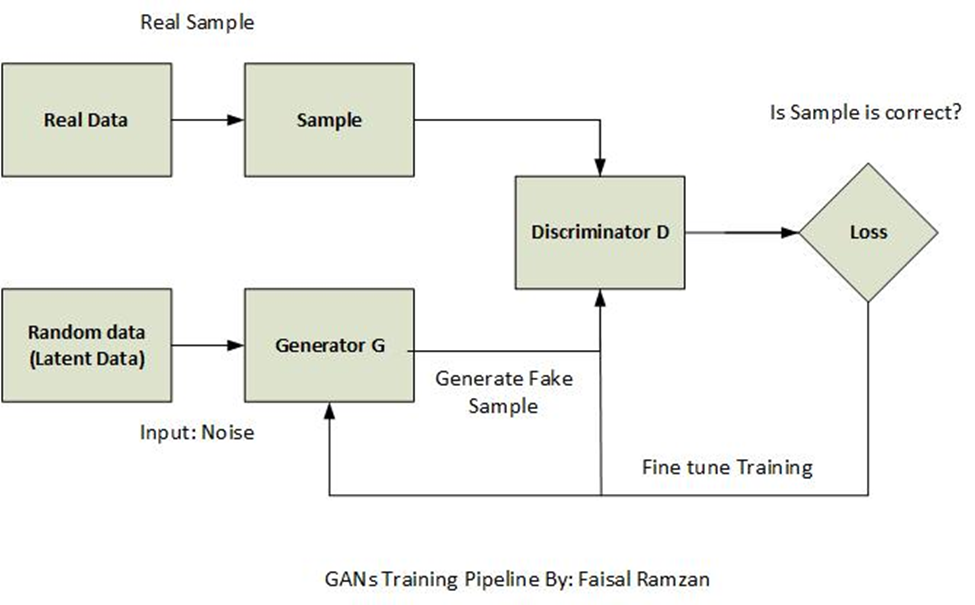

latent points
----

First step, with the help of generate_latent_points function, it will create random noise in the latent space and be reshaped to the dimensions for matching the input of generator model.

Latent space is responsible to generate random noise points in the space and reshaped them into such dimension that generator take those point as an input. Generator G take takes latent point as an input and produce the fake sample, the label of those fake point will be 0. From the real data we select some random real sample and label of those point is 1.

In [ ]:
# generate points in latent space
def generate_latent_points(latent_dim, n_samples):
	# generate random points (Noise in the latent point)
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [ ]:
# use the generator to generate n fake examples, responsibe to generate noise
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs with fake values
	X = generator.predict(x_input)
	# create class labels
	y = np.zeros((n_samples, 1)) # reshape the generated sample, for the fake or synthetic data we use 0
	return X, y

Real sample
---
generate_real_sample function is to generate real samples, it will randomly select samples from the real dataset (input).

In [ ]:
# generate n real samples with class labels
def generate_real_samples(n):
    X = dt.sample(n)
  #generate class labels
    y = np.ones((n, 1))  # this is label for real or original data
    return X, y


Generator Model
---

The generator G can use the outcome from the discriminator, the generator can generate the data that can be classified by the discriminator as the real data or real samples. The neural network architecture of the generator model is similar to the discriminator. The generator takes the random latent noisy point as an input and those point can be classified from the discriminator, the classification result from discriminator is a generator loss which punish the generator because of non-fooling the discriminator model. Generator can only rely on the latent point or generated noisy distribution to generate the fake samples and those fake samples can feed as input to the discriminator because of the classification purpose between the real and fake samples.


In [ ]:
# define the standalone generator model
def define_generator(latent_dim, n_outputs=4):
  model = Sequential()
  model.add(Dense(10, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))#8
  model.add(Dense(25, activation='relu'))#16
  model.add(Dense(n_outputs, activation='linear'))
  return model

In [ ]:
generator1 = define_generator(10, 4)   #latent_dimension 10 and the number of  output  can be same as  the number of input feature
generator1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                110       
                                                                 
 dense_1 (Dense)             (None, 25)                275       
                                                                 
 dense_2 (Dense)             (None, 4)                 104       
                                                                 
Total params: 489
Trainable params: 489
Non-trainable params: 0
_________________________________________________________________


**Descriminator Model**

The GANs model work as the two-player game, the discriminator D is a classifier that receive the real and synthetic point from the generator G and start to classify between the real and fake samples. Discriminator D is simple sequential keras model including dense layers, it depends on the designer of the model that how many numbers of layers used in the model, the purpose of these layer to extract the input features and the output of these layers are activated with “Relu” function. The activation function is responsible to transform the feature into the next layer. Rectified linear activation function can work on only positive number otherwise it will return with 0 (if x>0 return 1 else 0). The final or output layer in the discriminator model can be activated by the “sigmoid” activation function because this layer is used for the classification purpose to discriminate the input sample are real (1) or fake (0).

In [ ]:
# define the standalone discriminator model
def define_discriminator(n_inputs=4):
  model = Sequential()
  #model.add(BatchNormalization())
  model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs)) # we use sigmoid because we need to  classify the real and fake data
  model.add(Dense(50, activation='relu'))
  model.add(Dense(1, activation='sigmoid')) # classification layer
	# compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
discriminator1 = define_discriminator(4)
discriminator1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 25)                125       
                                                                 
 dense_4 (Dense)             (None, 50)                1300      
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,476
Trainable params: 1,476
Non-trainable params: 0
_________________________________________________________________


It is also a sequential model and combine generator with discriminator. NOTE: the discriminator model weight must be not trainable

In [ ]:
# combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

In [ ]:
!pip install plot_keras_history

  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.30-py3-none-any.whl size=8793 sha256=82fb67db31f087a0b84079714204574f2aeae23f30050baf0ee932c498cd7909
  Stored in directory: /root/.cache/pip/wheels/b0/60/47/8c5aa37c06be5e97879ec467bc2e6a30b315d95f662c63a503
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.29-py3-none-any.whl size=7877 sha256=8f061e530963d3e3c4523f24d355157844f13081b7013ba9b4db24f48a58fe3d
  Stored in directory: /root/.cache/pip/wheels/c2/f5/71/d1c459da10abec864a1979b449edbf37d4a82ab3e38a3625a8
  Created wheel for compress-json: filename=compress_json-1.0.4-py3-none-any.whl size=4585 sha256=7edbe9bec8ec1b59ed1e7528f330e3b6b41d5d51e016f60bc1ed967025c7b3ed
  Stored in directory: /root/.cache/pip/wheels/1e/ef/1e/5d403c5632b0462471a8d26049d0c138134d0255ec60ce4c14
Successfully built plot-keras-history sanitize-ml-labels compress-json


In [ ]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
# create a line plot of loss for the gan and save to file
def plot_history(d_hist, g_hist):
	# plot loss
	plt.subplot(1, 1, 1)
	plt.plot(d_hist, label='d')
	plt.plot(g_hist, label='gen')
	plt.show()
	plt.close()

**Model Training**
---

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=1000, n_batch=128):

  # determine half the size of one batch, for updating the discriminator
  half_batch = int(n_batch / 2)
  d_history = []
  g_history = []

  # manually enumerate epochs
  for epoch in range(n_epochs):
    # prepare real samples
    x_real, y_real = generate_real_samples(half_batch)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
    # update discriminator and training on real sampe called x_real
    d_loss_real, d_real_acc = d_model.train_on_batch(x_real, y_real)
    d_loss_fake, d_fake_acc = d_model.train_on_batch(x_fake, y_fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # prepare points in latent space as input for the generator
    x_gan = generate_latent_points(latent_dim, n_batch)

    # create inverted labels for the fake samples
    y_gan = np.ones((n_batch, 1))

    # update the generator via the discriminator's error or loss which penalize the G and retrained model again
    g_loss_fake = gan_model.train_on_batch(x_gan, y_gan)
    #print('>%d, D_real_loss=%.3f, D_fake_loss=%.3f d_combine_loss=%.3f gan_loss=%.3f' % (epoch+1, d_loss_real, d_loss_fake, d_loss,  g_loss_fake))
    print('>%d, d1=%.3f, d2=%.3f d=%.3f g=%.3f' % (epoch+1, d_loss_real, d_loss_fake, d_loss,  g_loss_fake))
    d_history.append(d_loss)
    g_history.append(g_loss_fake)

  plot_history(d_history, g_history)
  g_model.save('trained_generated_model_20210205_v3.h5')

In [ ]:
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
	# prepare real samples
	x_real, y_real = generate_real_samples(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print(epoch, acc_real, acc_fake)
  # scatter plot real and fake data points
	pyplot.scatter(x_real[:, 0], color='red')
	pyplot.scatter(x_fake[:, 0], color='blue')
	pyplot.show()

Given a small latent space, the AE produces low quality and the GAN
produces high quality outputs from a perceptual viewpoint. In contrast, the distortion error is smaller for the AE. By increasing the dimensionality of the latent space the distortion decreases for both models, but the perceptual quality only increases for the AE. ref: https://openreview.net/forum?id=Hygy01StvH

>1, d1=0.693, d2=0.753 d=0.723 g=0.636
>2, d1=0.687, d2=0.753 d=0.720 g=0.652
>3, d1=0.684, d2=0.743 d=0.714 g=0.660
>4, d1=0.682, d2=0.713 d=0.698 g=0.682
>5, d1=0.681, d2=0.697 d=0.689 g=0.702
>6, d1=0.679, d2=0.670 d=0.675 g=0.722
>7, d1=0.677, d2=0.657 d=0.667 g=0.740
>8, d1=0.677, d2=0.634 d=0.655 g=0.771
>9, d1=0.675, d2=0.615 d=0.645 g=0.781
>10, d1=0.673, d2=0.605 d=0.639 g=0.806
>11, d1=0.673, d2=0.596 d=0.635 g=0.824
>12, d1=0.671, d2=0.561 d=0.616 g=0.852
>13, d1=0.669, d2=0.562 d=0.616 g=0.865
>14, d1=0.667, d2=0.548 d=0.608 g=0.909
>15, d1=0.667, d2=0.514 d=0.591 g=0.904
>16, d1=0.665, d2=0.521 d=0.593 g=0.919
>17, d1=0.664, d2=0.530 d=0.597 g=0.954
>18, d1=0.662, d2=0.525 d=0.593 g=0.929
>19, d1=0.661, d2=0.515 d=0.588 g=0.961
>20, d1=0.660, d2=0.504 d=0.582 g=0.974
>21, d1=0.659, d2=0.490 d=0.574 g=0.991
>22, d1=0.658, d2=0.505 d=0.581 g=0.978
>23, d1=0.657, d2=0.494 d=0.575 g=0.982
>24, d1=0.655, d2=0.478 d=0.566 g=0.985
>25, d1=0.654, d2=0.492 d=0.573 g=1.048
>26, d1=0

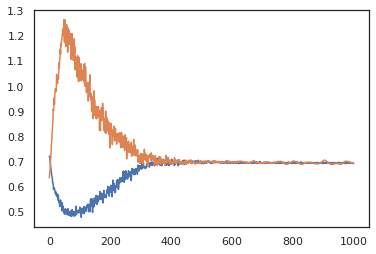

In [ ]:
# size of the latent space
latent_dim = 10
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)

**Evaluate the Quality of Generated Fake Data**
---


In [ ]:
# load the save model
from keras.models import load_model
model = load_model('/content/trained_generated_model_20210205_v3.h5')

In [ ]:
#save the model weights
weights = model.get_weights() # Getting parameters from the model
weights=pd.DataFrame(weights)
weights.to_csv('parameters.csv', index=False, header=None)

/usr/local/lib/python3.7/dist-packages/pandas/core/internals/construction.py:305: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [ ]:
latent_points = generate_latent_points(10, 408)  # we use according to our dataset

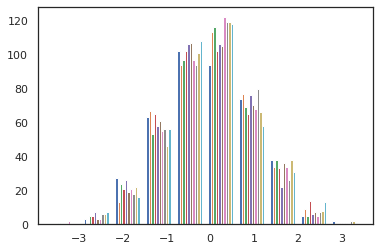

In [ ]:
plt.hist(latent_points,bins=10)
plt.show()

In [ ]:
Noise=pd.DataFrame(latent_points)

In [ ]:
#download the csv of fake data or Noisy point
Noise.to_csv('Noise.csv', index=False, header=None)

In [ ]:
Noise.head()

,0,1,2,3,4,5,6,7,8,9
0,0.263688,0.243480,0.505505,-0.138795,0.408125,0.010247,-0.714822,2.888399,0.819823,-0.824297
1,1.278603,-1.135201,1.406485,1.008432,0.920692,-0.847510,-0.296822,-1.470172,0.392082,0.576482
2,1.641741,0.310287,0.297887,1.107715,0.700864,-0.914171,-0.768724,1.780410,-1.406328,-0.165466
3,1.043435,1.465574,0.145300,0.777723,0.661294,0.120697,1.207183,-0.034468,0.055959,-0.361968
4,-1.357811,1.361454,0.168076,-0.876413,-0.803173,-1.330124,-0.259774,0.456866,-0.070540,1.151124


In [ ]:
X = model.predict(Noise)

In [ ]:
data_fake = pd.DataFrame(data=X)

In [ ]:
#download the csv of fake data
data_fake.to_csv('Data.csv', index=False,header=None)

In [ ]:
data_fake.head()

,0,1,2,3
0,0.020167,-0.003071,0.009759,0.013813
1,0.017501,-0.001190,0.001552,-0.003804
2,0.015769,0.003850,0.008949,0.012402
3,0.022868,0.008320,0.012518,0.008774
4,0.002438,0.004125,0.002312,0.005144


In [ ]:
print('Description of Synthetic data\n',data_fake.describe())
print('Description of real data\n',dt.describe())

Description of Synthetic data
                 0           1           2           3
count  408.000000  408.000000  408.000000  408.000000
mean     0.011599    0.004685    0.006150    0.009681
std      0.008182    0.004419    0.005471    0.005470
min     -0.005858   -0.007954   -0.009611   -0.007244
25%      0.005630    0.002404    0.002989    0.005773
50%      0.009673    0.004633    0.005336    0.008469
75%      0.016263    0.006736    0.008662    0.012682
max      0.037675    0.034274    0.033964    0.029403
Description of real data
                 0           1           2           3
count  746.000000  746.000000  746.000000  746.000000
mean     0.013144    0.012822    0.009366    0.010788
std      0.011914    0.011712    0.009283    0.009338
min      0.000012    0.000057    0.000014    0.000067
25%      0.004761    0.003878    0.003202    0.004226
50%      0.010030    0.009423    0.006641    0.008508
75%      0.017771    0.017810    0.012354    0.014221
max      0.098709    0.08

**Evaluate the Quality of Generated Fake Data With Table_evaluator**
---
Table_evaluator is a library to evaluate how similar a synthesized dataset is to a real dataset. It is suitable for evaluating the generated synthetic data. First we will install the table_evaluator module.


In [ ]:
!pip install table_evaluator

In [ ]:
from table_evaluator import load_data, TableEvaluator
table_evaluator = TableEvaluator(dt, data_fake)

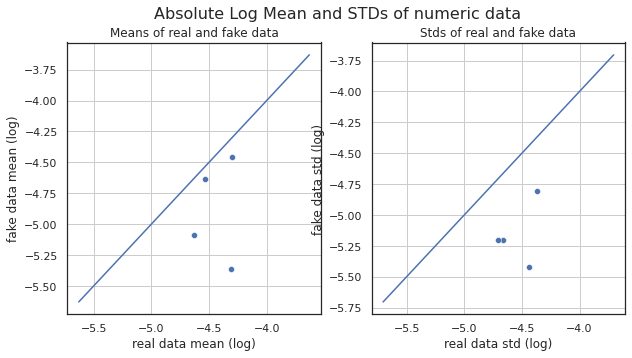

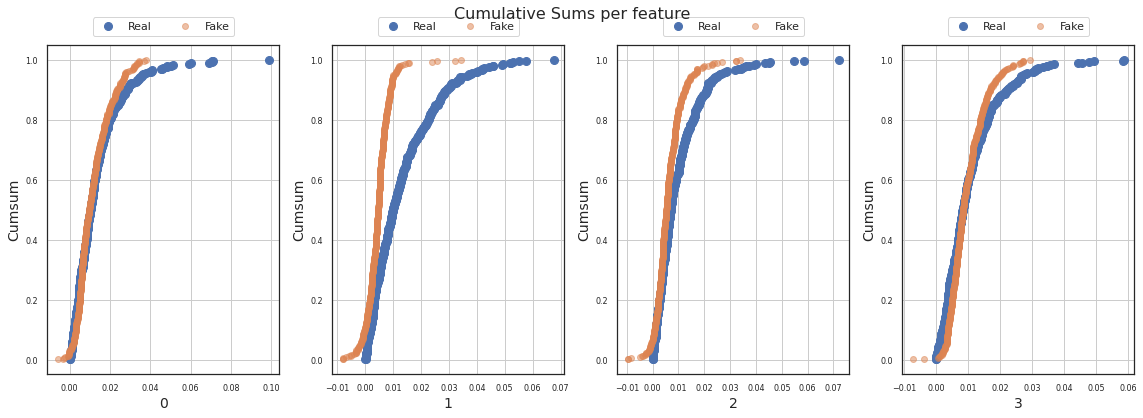

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/di

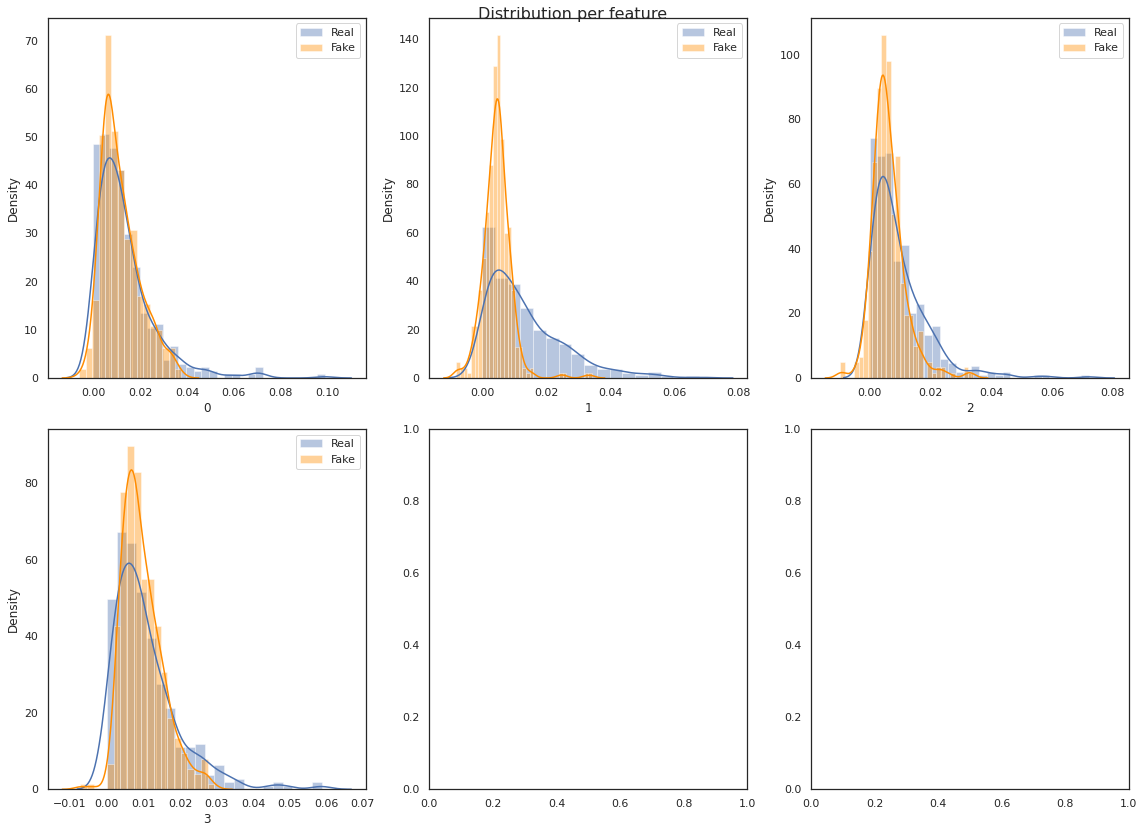

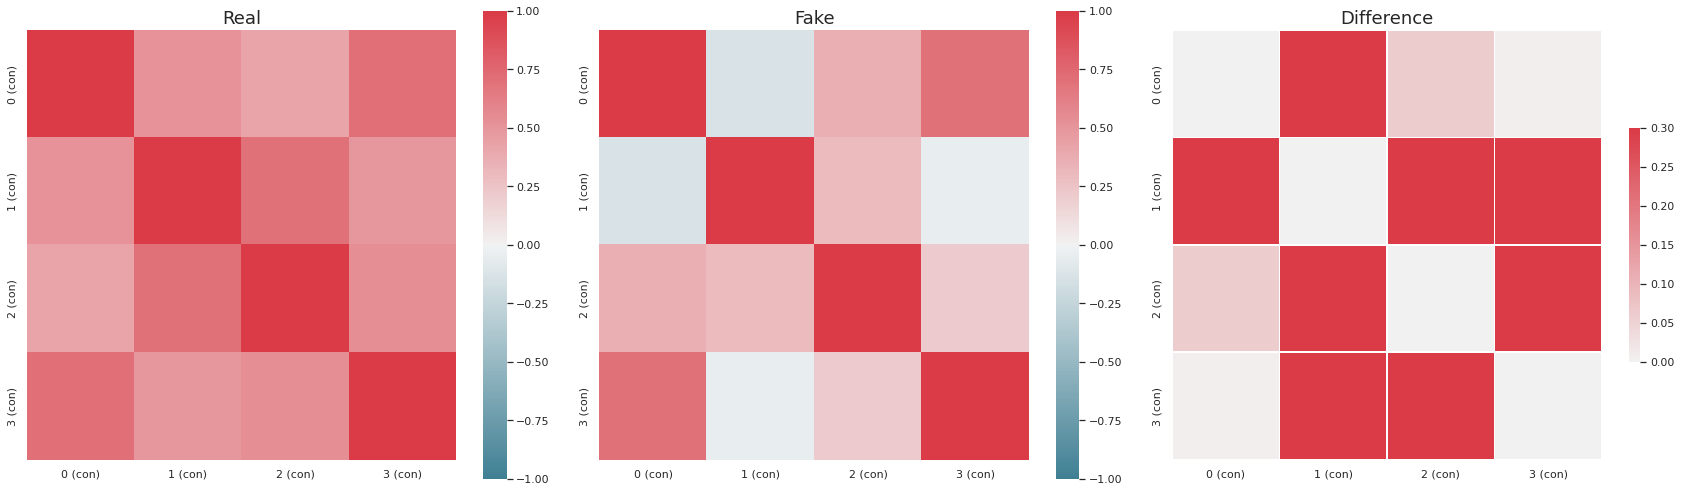

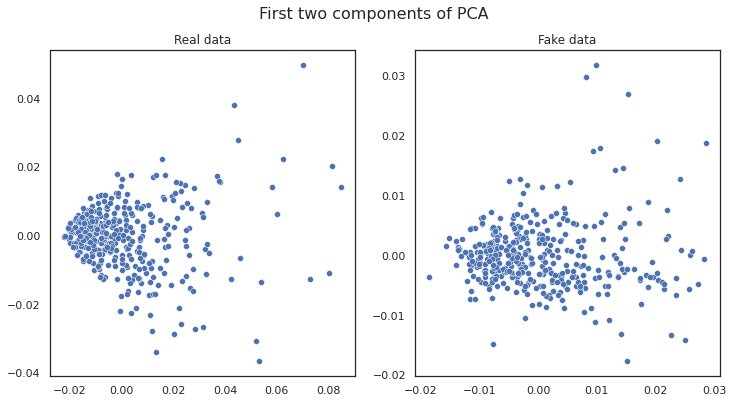

In [ ]:
table_evaluator.visual_evaluation()

Distribution plot
---


Blue show the original while the Orange show the Synthetic Data or Newly generated data:


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



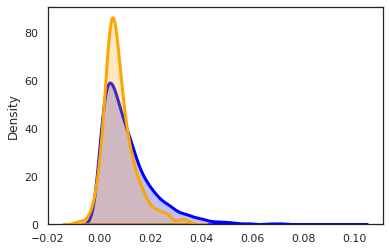

In [ ]:
import seaborn as sns
print('Blue show the original while the Orange show the Synthetic Data or Newly generated data:')
sns.distplot(dt, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},
                  label = dt, color='blue');
sns.distplot(data_fake, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},
                  label = dt, color='Orange');
plt.show()


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



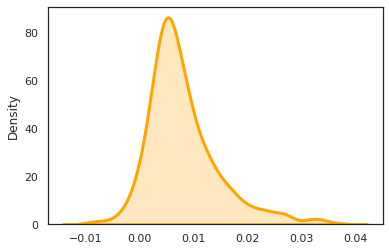

In [ ]:
import seaborn as sns
sns.distplot(data_fake, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},
                  label = dt, color='orange')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



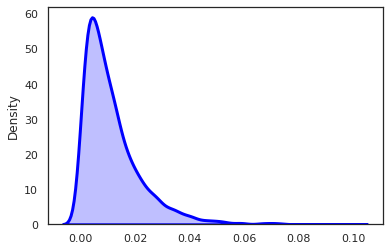

In [ ]:
import seaborn as sns
sns.distplot(dt, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},
                  label = dt,color='blue')